In [158]:
import matplotlib
import matplotlib.pyplot as plt

model_dict = {
    "ucc": {
        "experiment_id":"546114710104461663",
        "run_id":"e3e102e875734beb84c3ccb6ca2f46e4"
    },
    "ucc-drn-1-wasserstein": {
        "experiment_id": "545254671228892812",
        "run_id":"59194205951142bd832a43b511edb19d"
    },
    "ucc-drn": {
        "experiment_id": "189454739472380536",
        "run_id":"98d0cca708cc4f5ba40314aa134af4cd"
    },
    "ucc-drn-jsd": {
        "experiment_id": "657963627447301561",
        "run_id": "8b5480c32a224f23803e7d69082e41ba"
    },
    # "ucc-jsd":{
    #     "experiment_id": "596489502680300638",
    #     "run_id": "fa6a16db72a1463d830680170e3f489f"
    # }
}

In [ ]:
import mlflow

runs = mlflow.search_runs(experiment_ids=[x["experiment_id"] for _, x in model_dict.items()], output_format="list")
filtered_runs = [run for run in runs  if run.info.run_id in [x["run_id"] for _, x in model_dict.items()]]

In [160]:
def get_parent_run(run_name, run_id, parent_list):
    if "resume" not in run_name:
        parent_list.append({"run_name": run_name, "run_id": run_id})
        return
    else:
        parent_list.append({"run_name": run_name, "run_id": run_id})
        parent_run_id = run_name.replace("_resume", "")
        parent_run = [run.info.run_name for run in runs if run.info.run_id == parent_run_id ]
        get_parent_run(parent_run[0], parent_run_id, parent_list)


In [161]:
def exponential_moving_average(data, alpha=0.3):
    ema = []
    for i, val in enumerate(data):
        if i == 0:
            ema.append(val)
        else:
            ema.append(alpha * val + (1 - alpha) * ema[-1])
    return ema

In [162]:
from collections import defaultdict

client = mlflow.MlflowClient()
experiment_id_to_name_map = {x["experiment_id"]: name for name, x in model_dict.items()}
full_metric_dict = defaultdict(dict)
for run in filtered_runs:
    experiment_id = run.info.experiment_id
    run_id = run.info.run_id
    run_name = run.info.run_name
    model_name = experiment_id_to_name_map[experiment_id]
    metric_names = ["eval_ae_loss", "eval_ucc_loss", "eval_ucc_acc", "train_ae_loss", "train_ucc_loss", "train_ucc_acc"]
    if "_resume" in run_name:
        p_list = []
        get_parent_run(run_name, run_id, p_list)
        p_list = list(reversed(p_list))
        metric_dict = defaultdict(list)
        for values in p_list:
            run_id = values["run_id"]
            run_name = values["run_name"]
            for metric in metric_names:
                metric_history = client.get_metric_history(run_id, metric)
                metric_dict[metric]+= metric_history
        for metric in metric_names:
            full_metric_dict[metric][model_name] = metric_dict[metric]
    else:
        for metric in metric_names:
            metric_history = client.get_metric_history(run_id, metric)
            full_metric_dict[metric][model_name] = metric_history
    # print(full_metric_dict["eval_ae_loss"].keys())
    # model_name = f"{model_name}_{experiment_id}_{run_id}"
    

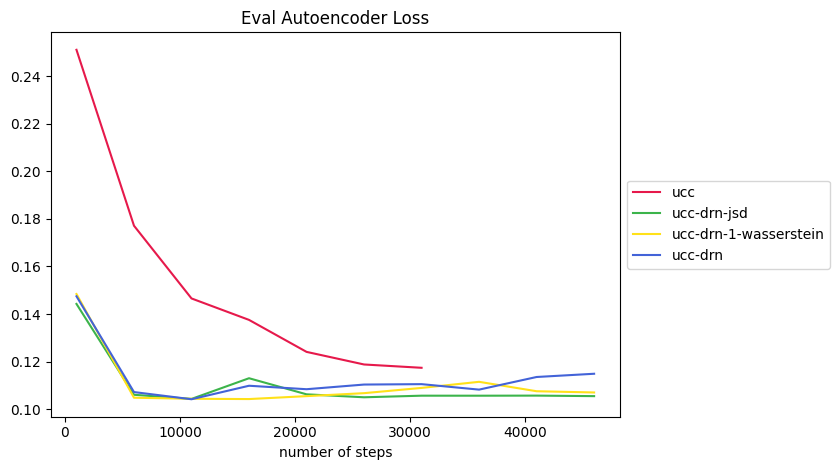

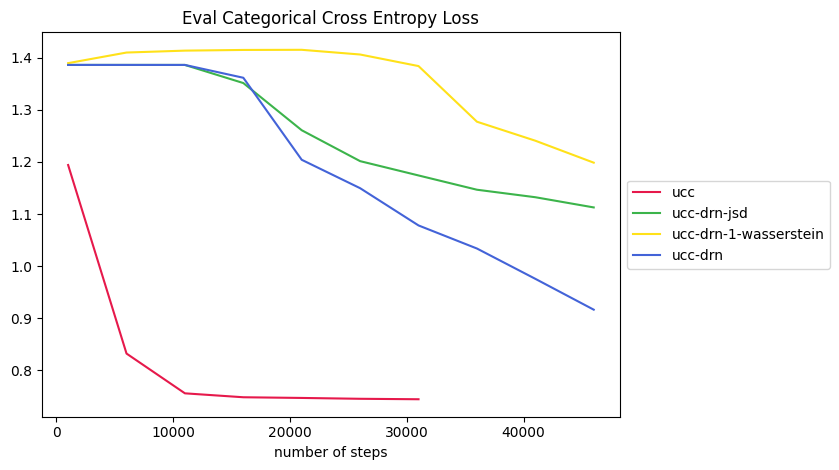

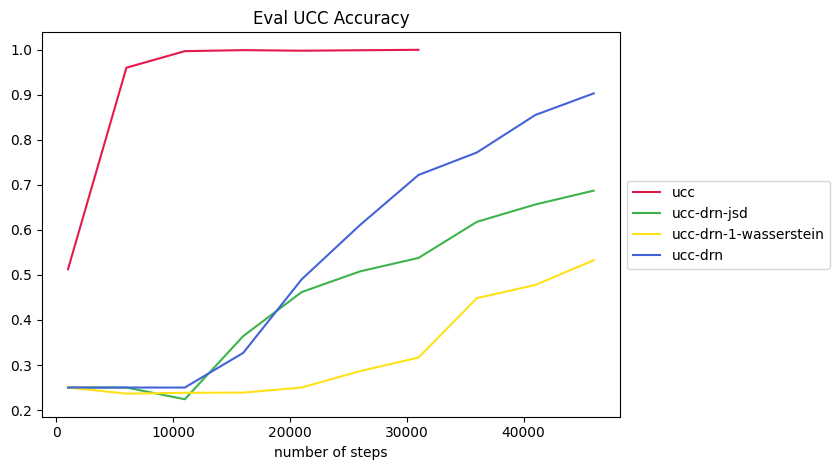

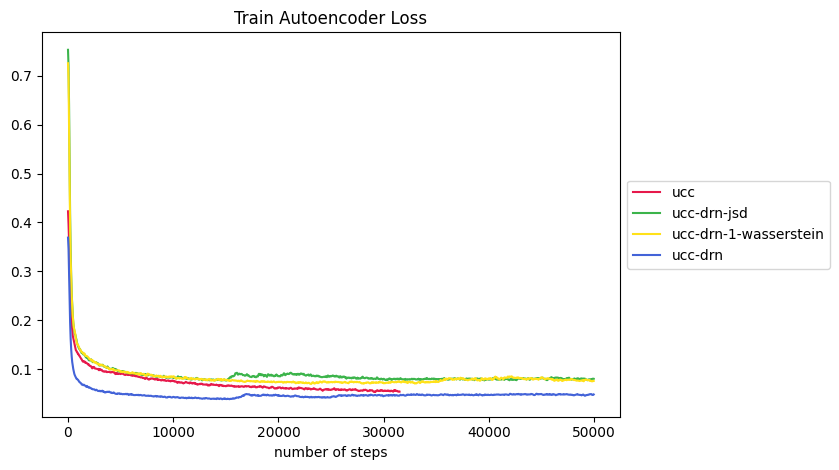

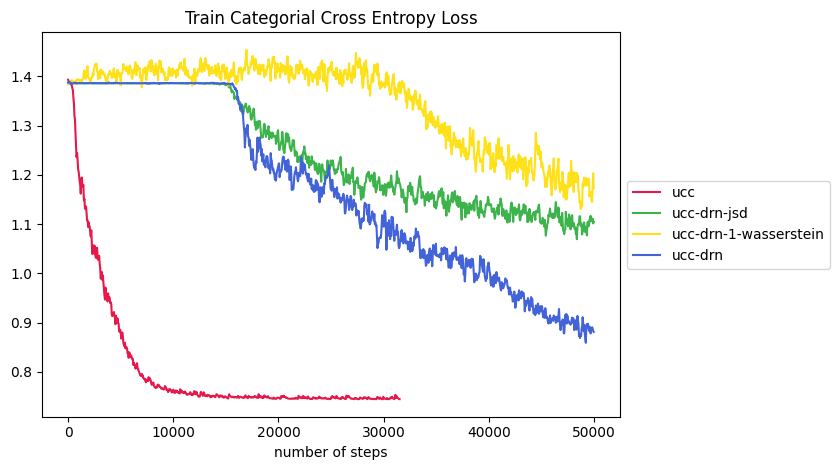

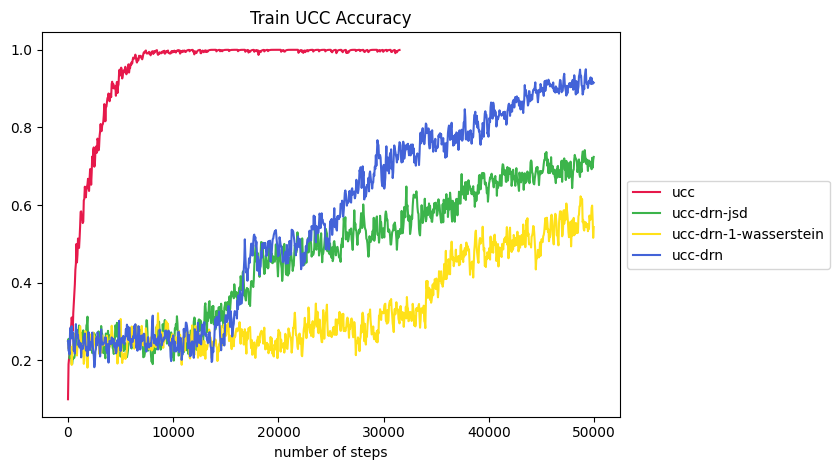

In [168]:
import numpy as np
from matplotlib.lines import Line2D
m_color = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

metric_to_graph_label = {
    "eval_ae_loss": "Eval Autoencoder Loss", 
    "eval_ucc_loss": "Eval Categorical Cross Entropy Loss",
    "eval_ucc_acc": "Eval UCC Accuracy", 
    "train_ae_loss": "Train Autoencoder Loss", 
    "train_ucc_loss": "Train Categorial Cross Entropy Loss", 
    "train_ucc_acc": "Train UCC Accuracy",
}

for metric, name_metric_dict in full_metric_dict.items():
    maximum_steps = max([met[-1].step for _, met in name_metric_dict.items()])
    fig = plt.figure()
    index = 0
    for name, met in name_metric_dict.items():
        values = [m.value for m in met if m.step<=50000]
        steps = [m.step for m in met if m.step<=50000]
        interval = len(values)//10
        if 'train' in metric:
            smoothed_values = exponential_moving_average(values, 0.1)
        else:
            smoothed_values= values
        plt.plot([x for index, x in enumerate(steps) if index%5==0], [x for index, x in enumerate(smoothed_values) if index%5==0], color = m_color[index])
        plt.xlabel("number of steps")
        # plt.scatter([x for index, x in enumerate(steps) if index%10==0], [x for index, x in enumerate(smoothed_values) if index%10==0], color = m_color[index])
        plt.title(metric_to_graph_label[metric])
        index+=1
    name_list = list(name_metric_dict.keys())
    legend_handles = [
    Line2D([0], [0], color=c, linestyle="-", label=name) for c, name in zip(m_color[:len(name_list)], name_list)]
    
    plt.tight_layout()
    plt.legend(handles=legend_handles, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.savefig(f"evaluation/{metric}.png", dpi=100, bbox_inches='tight')
    # for model_name, m_list in name_metric_dict.items():
        

In [46]:
full_metric_dict["eval_ucc_loss"].keys()

dict_keys(['drn_cross_entropy'])

In [44]:
name_metric_dict.keys()

dict_keys(['drn_cross_entropy'])

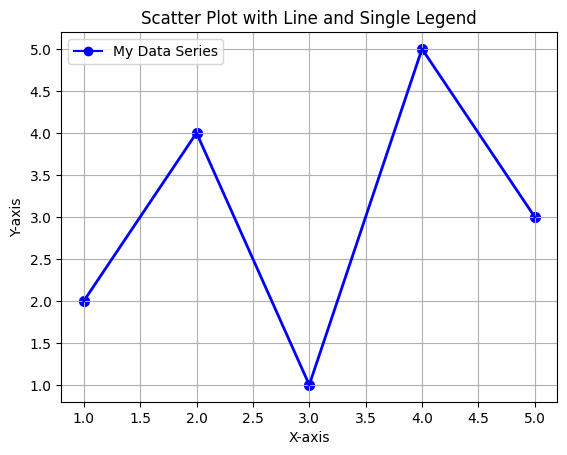

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Sample data
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 1, 5, 3])

fig, ax = plt.subplots()

# Plot the line (without a label)
ax.plot(x, y, color='blue', linestyle='-', linewidth=2)

# Plot the scatter points (without a label)
ax.scatter(x, y, color='blue', marker='o', s=50)

# Create a custom legend handle that combines line and scatter marker
custom_legend_handle = Line2D([0], [0], color='blue', marker='o', linestyle='-',
                              label='My Data Series')

# Add the custom legend to the plot
ax.legend(handles=[custom_legend_handle])

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Line and Single Legend')
plt.grid(True)
plt.show()

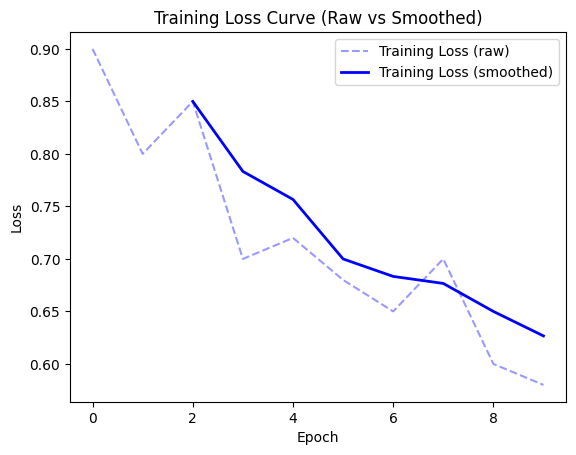

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Example raw training losses (jagged)
train_losses = [0.9, 0.8, 0.85, 0.7, 0.72, 0.68, 0.65, 0.7, 0.6, 0.58]

# Moving average smoothing
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_losses = moving_average(train_losses, window_size=3)

# Plot raw curve (thin + faint)
plt.plot(train_losses, label="Training Loss (raw)", color="blue", alpha=0.4, linestyle="--")

# Plot smoothed curve (bold on top)
plt.plot(range(2, len(train_losses)), smoothed_losses, 
         label="Training Loss (smoothed)", color="blue", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve (Raw vs Smoothed)")
plt.legend()
plt.show()

In [131]:
# cleaning ucc_loss

train_ucc_loss_file = "mlruns/546114710104461663/7c24bf957e124296b63ed412e33a76d7/metrics/train_ucc_loss"
train_ae_loss_file = "mlruns/546114710104461663/7c24bf957e124296b63ed412e33a76d7/metrics/train_ae_loss"
train_loss_file = "mlruns/546114710104461663/7c24bf957e124296b63ed412e33a76d7/metrics/loss"
with open(train_ucc_loss_file, "r") as file:
    ucc_string = file.read()
with open(train_ae_loss_file, "r") as file:
    ae_string = file.read()
with open(train_loss_file, "r") as file:
    loss_string = file.read()
train_ucc_loss_steps = ucc_string.split("\n")
train_loss_steps = loss_string.split("\n")
train_ae_loss_steps = ae_string.split("\n")

actual_train_ucc_steps = []
for ucc, loss, ae in zip(train_ucc_loss_steps, train_loss_steps, train_ae_loss_steps):
    if loss:
        original_ucc_list = ucc.split(" ")
        actual_value = 2*(float(loss.split(" ")[1]) - float(ae.split(" ")[1]))
        original_ucc_list[1] = str(round(actual_value, 5))
        actual_train_ucc_steps.append(" ".join(original_ucc_list))

with open(train_ucc_loss_file, "w") as file:
    file.write("\n".join(actual_train_ucc_steps))

'1752102975717 0.39797 200000'

'1752102975717 0.79594 200000'

In [ ]:
actual_train_ucc_loss

[0.40372,
 0.37572,
 0.38065,
 0.37724,
 0.40573,
 0.38663,
 0.37726,
 0.37388,
 0.38149,
 0.38986,
 0.37654,
 0.37492,
 0.375,
 0.40146,
 0.37513,
 0.39198,
 0.40131,
 0.37797,
 0.37365,
 0.37595,
 0.37789,
 0.40005,
 0.38599,
 0.39168,
 0.40455,
 0.39014,
 0.37703,
 0.37913,
 0.37567,
 0.38992,
 0.40128,
 0.37618,
 0.40095,
 0.37964,
 0.38062,
 0.3742,
 0.37573,
 0.3775,
 0.37623,
 0.38639,
 0.39687,
 0.37452,
 0.3753,
 0.38349,
 0.37454,
 0.38421,
 0.40145,
 0.37958,
 0.37572,
 0.38117,
 0.38135,
 0.39803,
 0.39213,
 0.41932,
 0.37649,
 0.37626,
 0.39739,
 0.39052,
 0.37723,
 0.37808,
 0.40104,
 0.39594,
 0.39404,
 0.38575,
 0.37425,
 0.37751,
 0.3994,
 0.37896,
 0.39712,
 0.37514,
 0.37514,
 0.37793,
 0.39206,
 0.38612,
 0.37835,
 0.38922,
 0.42428,
 0.38153,
 0.40656,
 0.41031,
 0.37944,
 0.38552,
 0.38257,
 0.3745,
 0.37526,
 0.40398,
 0.39274,
 0.4237,
 0.37508,
 0.39258,
 0.38076,
 0.37518,
 0.37638,
 0.38848,
 0.41075,
 0.37525,
 0.37681,
 0.42417,
 0.37586,
 0.38242,
 0.3845,

In [106]:
steps

['1752030566566 0.40372 133010',
 '1752030572491 0.37572 133020',
 '1752030578327 0.38065 133030',
 '1752030584143 0.37724 133040',
 '1752030590048 0.40573 133050',
 '1752030596417 0.38663 133060',
 '1752030602239 0.37726 133070',
 '1752030608086 0.37388 133080',
 '1752030613851 0.38149 133090',
 '1752030620163 0.38986 133100',
 '1752030626115 0.37654 133110',
 '1752030632337 0.37492 133120',
 '1752030638078 0.375 133130',
 '1752030643901 0.40146 133140',
 '1752030649726 0.37513 133150',
 '1752030655944 0.39198 133160',
 '1752030661801 0.40131 133170',
 '1752030667563 0.37797 133180',
 '1752030673507 0.37365 133190',
 '1752030679746 0.37595 133200',
 '1752030685662 0.37789 133210',
 '1752030691894 0.40005 133220',
 '1752030697913 0.38599 133230',
 '1752030703840 0.39168 133240',
 '1752030709642 0.40455 133250',
 '1752030715591 0.39014 133260',
 '1752030721737 0.37703 133270',
 '1752030727918 0.37913 133280',
 '1752030733950 0.37567 133290',
 '1752030740034 0.38992 133300',
 '1752030745